In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from numpy.matlib import zeros, ones, identity
from math import sin, cos, atan2, pi
from IPython.display import display, Math, Latex, Markdown, HTML

# ICP #
This notebook is all about ICP and it's different implementations. It should be visual and self - descriptive.

## Overview ##
Having two scans $P = \{p_i\}$ and $Q = \{q_i\}$ we want to find a transformation (rotation $R$ and translation $t$) to apply to $P$ to match $Q$ as good as possible:

\begin{equation}
E = \sum_i[Rp_i + t - q_i]^2 \rightarrow \mathrm{min} 
\end{equation}

Here, we consider corresponding points. We will focus on **single iteration of icp** here.

## We plot data like this: ##

In [2]:
# plot the data
def plot_data(data_1, data_2, label_1='P', label_2='Q', xlim=[-5, 20], ylim=[-5, 20]):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    x_p, y_p = data_1.A
    x_q, y_q = data_2.A
    ax.plot(x_p, y_p, color='blue', marker='o', label=label_1)
    ax.plot(x_q, y_q, color='red', marker='o', label=label_2)
    ax.legend()
    return ax

## Example data: ##

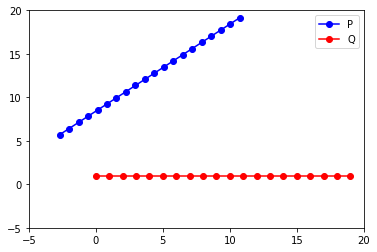

In [3]:
# initialize pertrubation rotation
angle = pi / 4
R_true = np.mat([[cos(angle), -sin(angle)], 
                 [sin(angle),  cos(angle)]])
t_true = np.mat([[-2], [5]])

# generate data as a list of 2d points
num_points = 20
Q = ones((2, num_points))
Q[0, :] = range(0, num_points)
P = R_true * Q + t_true
plot_data(P, Q)
plt.show()

## Centered data: ##

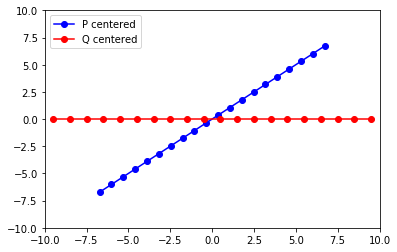

In [4]:
mu_P = P.mean(1)
mu_Q = Q.mean(1)
P_centered = P - mu_P
Q_centered = Q - mu_Q
lim = [-10, 10]
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered',
               xlim=lim, ylim=lim)
plt.show()

## Correspondences: ##
We compute correspondences from $P$ to $Q$, i.e. for every $p_i$ we search the closest $q_j$ to it.

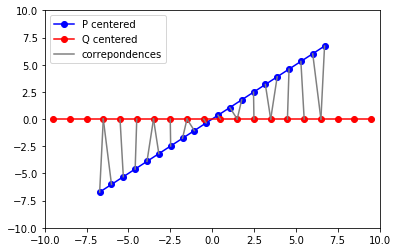

In [5]:
def get_correspondence_indices(P, Q):
    """For each point in P find closest one in Q."""
    p_size = P.shape[1]
    q_size = Q.shape[1]
    correspondences = []
    for i in range(p_size):
        p_point = P[:, i]
        min_dist = sys.maxsize
        chosen_idx = -1
        for j in range(q_size):
            q_point = Q[:, j]
            dist = np.linalg.norm(q_point - p_point)
            if dist < min_dist:
                min_dist = dist
                chosen_idx = j
        correspondences.append((i, chosen_idx))
    return correspondences

def draw_correspondeces(P, Q, correspondences, ax):
    label_added = False
    for i, j in correspondences:
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        if not label_added:
            ax.plot(x, y, color='grey', label='correpondences')
            label_added = True
        else:
            ax.plot(x, y, color='grey')
    ax.legend()

correspondences = get_correspondence_indices(P_centered, Q_centered)
lim = [-10, 10]
ax = plot_data(P_centered, Q_centered,
               label_1='P centered',
               label_2='Q centered',
               xlim=lim, ylim=lim)
draw_correspondeces(P_centered, Q_centered, correspondences, ax)
plt.show()

## SVD - based ICP ##

#### Single iteration ####
In a single iteration we assume that the correspondences are known. We can compute the cross-correlation between the corresponding points. Let $C = \{\{i,j\}:p_i \leftrightarrow q_j\}$ be a set of all correspondences, also $|C| = N$. Then, the cross correlation $K$ is computed as:

\begin{eqnarray}
K &=& E [(q_i - \mu_Q)(p_i - \mu_P)^T] \\
&=& \frac{1}{N}\sum_{\{i,j\} \in C}{(q_i - \mu_Q)(p_i - \mu_P)^T} \\
&\sim& \sum_{\{i,j\} \in C}{(q_i - \mu_Q)(p_i - \mu_P)^T}
\end{eqnarray}

Each point has two dimentions, that is $p_i, q_j \in {\rm I\!R}$, thus cross correlation has the form of (we drop indices $i$ and $j$ for notation simplicity):

\begin{equation}
K =
  \begin{bmatrix}
    cov(p_x, q_x) & cov(p_x, q_y) \\
    cov(p_y, q_x) & cov(p_y, q_y)
  \end{bmatrix}
\end{equation}

Intuitevely, cross correlation tells us how a coordinate of point $q$ changes with the change of $p$ coorinate, i.e. $cov(p_x, q_x)$ tells us how the $x$ coordinate of $q$ will change with the change in $x$ coordinate of $p$ given that the points are corresponding. Ideal cross correlation matrix seems to be identity, i.e. we want the $x$ coordinates to be ideally correlated between the scans $P$ and $Q$, while there should be no correlation between the $x$ coorinate of points from $P$ to the $y$ coordinate of points in $Q$. 

**Example**: Given scans $P$ and $Q$ that match ideally and $\{p_i, q_j\} \in C$, we know that if we change the $x$ coordinate of $p_i$ we see exactly the same change in $x$ coordinate of $q_j$ while we observe no change in its $y$ coordinate. Therefore, the cross correlation matrix will be identity.

Knowing the cross correlation we can compute its SVD decomposition:

\begin{equation}
\mathrm{SVD}(K) = USV^T
\end{equation}

The SVD decomposition gives us how to rotate our data to align it with its prominent direction with $UV^T$ and how to scale it with its singular values $S$. Therefore:

\begin{eqnarray}
R &=& UV^T \\
t &=& \mu_Q - R \mu_P
\end{eqnarray}

#### Let's try this out: ####

## Compute cross covariance ##

In [6]:
def compute_cross_covariance(P, Q, correspondences):
    cov = zeros((2, 2))
    for i, j in correspondences:
        p_point = P[:, i]
        q_point = Q[:, j]
        cov += q_point * p_point.T
    return cov

cov = compute_cross_covariance(P_centered, Q_centered, correspondences)
print(cov)

[[335.87572106 335.87572106]
 [  0.           0.        ]]


## Find $R$ and $t$ from SVD decomposition ##
Here we find SVD decomposition of the cross covariance matrix and apply the rotation to $Q$

In [7]:
U, S, V_T = np.linalg.svd(cov)
print(S)
R_found = U * V_T
t_found = mu_Q - R_found * mu_P

[475.   0.]


## Apply correction to $P$ and visualize the result ##

[[-2.12132034]
 [-4.94974747]]
[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]


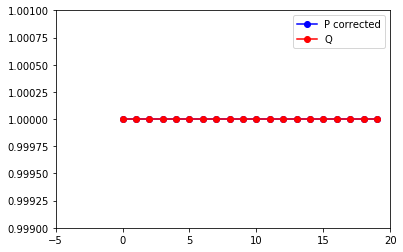

Squared diff: (P_corrected - Q) =  1.0338793578432984e-14


In [8]:
P_corrected = R_found * P + t_found
print(t_found)
print(R_found)
ax = plot_data(P_corrected, Q, label_1='P corrected', label_2='Q', ylim=[0.999, 1.001])
plt.show()
print("Squared diff: (P_corrected - Q) = ", np.linalg.norm(P_corrected - Q))

$\newcommand{\b}[1]{\boldsymbol{\mathrm{#1}}}$
$\newcommand{\R}{\boldsymbol{\mathrm{R}}}$
$\newcommand{\x}{\boldsymbol{\mathrm{x}}}$
$\newcommand{\h}{\boldsymbol{\mathrm{h}}}$
$\newcommand{\p}{\boldsymbol{\mathrm{p}}}$
$\newcommand{\q}{\boldsymbol{\mathrm{q}}}$
$\newcommand{\t}{\boldsymbol{\mathrm{t}}}$
$\newcommand{\J}{\boldsymbol{\mathrm{J}}}$
$\newcommand{\H}{\boldsymbol{\mathrm{H}}}$
$\newcommand{\E}{\boldsymbol{\mathrm{E}}}$
$\newcommand{\e}{\boldsymbol{\mathrm{e}}}$
$\DeclareMathOperator*{\argmin}{arg\,min}$
$\newcommand{\norm}[1]{\left\lVert#1\right\rVert}$
# Non-linear Least-squares based ICP #
We can alternatively treat every iteration of ICP as a least squares minimization problem. The function we want to minimize is the pose $\b{x} = [x, y, \theta]^T$ to which we need to move scan $P$ to overlap it with a query scan $Q$. It is a non-linear function because of the rotation as we will see later.

## Correspondeces ##
We look for correspondeces **without** moving the data to ensure zero-mean. Therefore the correspondences look worse than in SVD case, where we first ensured that both scans are zero-mean.

[[-2.70710678 -2.         -1.29289322 -0.58578644  0.12132034  0.82842712
   1.53553391  2.24264069  2.94974747  3.65685425  4.36396103  5.07106781
   5.77817459  6.48528137  7.19238816  7.89949494  8.60660172  9.3137085
  10.02081528 10.72792206]
 [ 5.70710678  6.41421356  7.12132034  7.82842712  8.53553391  9.24264069
   9.94974747 10.65685425 11.36396103 12.07106781 12.77817459 13.48528137
  14.19238816 14.89949494 15.60660172 16.3137085  17.02081528 17.72792206
  18.43502884 19.14213562]]


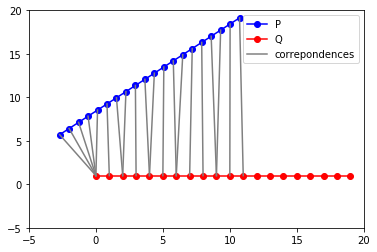

In [14]:
correspondences = get_correspondence_indices(P, Q)
ax = plot_data(P, Q)
draw_correspondeces(P, Q, correspondences, ax)
plt.show()

## Minimization ##
We define $\p_i \in P$ to be points we want to match against $\q_j \in Q$. By "matching" we mean finding pose $\b{x} = [x, y, \theta]^T$ that minimizes the sum of squared lengths of the correspondences. Pose $\x$ can alternatively be resresented by a rotation matrix $\R = 
\begin{bmatrix}
    \cos\theta & - \sin\theta \\
    \sin\theta & \cos\theta
\end{bmatrix}$ and a translation vector $\t = [x, y]^T$. We will keep using these representations interchangibly throughtout these notes. 

We will further use the following notation: $\h_i(\x) = \R_\theta \p_i + \t$ to denote the points from scan $P$ transformed with $\R$ and $\t$. Additionally, we define error function $\e$ to be: 

\begin{eqnarray}
\e(\x) &=& \sum_{\{i,j\}\in C}{\e_{i,j}(\x)},\\
\e_{i,j}(\x) &=& \h_i(\x) - \q_j
\end{eqnarray}


This allows us to formulate the minimization problem as follows:

\begin{eqnarray}
\b{x}_{query} 
&=& \argmin_{\x}\{\E(\x)\} \\
&=& \argmin_{\x}\{\sum_{\{i, j\} \in C}{\norm{\e_{i,j}(\x)}^2}\} \\ 
&=& \argmin_{\x}\{\sum_{\{i, j\} \in C}{\norm{\b{h}_i(\x) - \q_j}^2}\}
\end{eqnarray}

### Gauss Newton Method ###
We will be using Gauss Newton method for computing the least squares solution of our non-linear problem. We therefore linearize our function in the vicinity of $\x$. Solving non-linear least squares is equivalent to solving the following system of equations:

\begin{equation}
\H \Delta \x = - \E^\prime(\x),
\end{equation}

where $\Delta \x$ is the increment of the argument ($[\Delta x, \Delta y, \Delta \theta]$ in our case), $\H$ is the Hessian of $\E$ and $\E^\prime(\x)$ is the derivative over the function we are trying to minimize. 
We compute the gradient $\E^\prime(\x)$ as follows:

\begin{equation}
\E^\prime(\x) = \J(\x) \e(\x)
\end{equation}

In Gauss-Newton method we linearize the function around the considered point, which allows us to compute the Hessian as simple as: $\H = \J(\x)^T \J(\x)$

#### Jacobian ####
Both the Hessian and the gradient require the computation of a Jacobian. To compute a Jacobian we need a derivative of a rotation matrix:

\begin{equation}
\R_\theta^\prime
=\frac{\partial}{\partial \theta}
  \begin{bmatrix}
    \cos\theta & - \sin\theta \\
    \sin\theta & \cos\theta
  \end{bmatrix}
=\begin{bmatrix}
    -\sin\theta & - \cos\theta \\
    \cos\theta & -\sin\theta
  \end{bmatrix}
\end{equation}

In [10]:
def dR(theta):
    return np.matrix([[-sin(theta), -cos(theta)],
                      [cos(theta),  -sin(theta)]])

def R(theta):
    return np.matrix([[cos(theta), -sin(theta)],
                      [sin(theta),  cos(theta)]])

Now we have everything to compute the Jacobian $\b{J}$ as follows:

\begin{eqnarray}
\b{J} = \frac{\partial \e_{i,j}(\x)}{\partial \x} = \frac{\partial \h_i(\x)}{\partial \x} 
&=& \Big(\frac{\partial \h_i(\x)}{\partial x}, \frac{\partial \h_i(\x)}{\partial y}, \frac{\partial \h_i(\x)}{\partial \theta}\Big) \\ 
&=&\Big(\b{I}, \R_\theta^\prime \p_i \Big) \\ 
&=&
\begin{bmatrix}
    1 & 0 & -\sin\theta\ p_i^x - \cos\theta\ p_i^y \\
    0 & 1 & \cos\theta\ p_i^x - \sin\theta\ p_i^y
\end{bmatrix}
\end{eqnarray}

In [11]:
def jacobian(x, p_point):
    theta = x[2]
    J = zeros((2, 3))
    J[0:2, 0:2] = identity(2)
    J[0:2, 2] = dR(theta) * p_point
    return J

def error(x, p_point, q_point):
    rotation = R(x[2])
    translation = x[0:2]
    prediction = rotation * p_point + translation
    return prediction - q_point

## Least squares ##
Now that we know how to compute the Jacobian, we can compute the system of equations, solving which delivers the solution to our problem. We initialize Hessian $\H$ and gradient $\b{g}$ by zeros:

\begin{equation}
\b{H} = 
\begin{bmatrix}
    0 & 0 & 0 \\
    0 & 0 & 0 \\
    0 & 0 & 0
\end{bmatrix}, \ 
\b{g} = 
\begin{bmatrix}
    0 \\
    0 \\
    0
\end{bmatrix} \ 
\end{equation}

We now need to construct a system of equations solving which would give us the relative pose. **For every corresponding pair of points** do the following:

\begin{eqnarray}
\H &\rightarrow& \b{H} + \J^T \J \\
\b{g} &\rightarrow& \b{g} + \J^T \e
\end{eqnarray}

Now that the system of equation is ready, we can find the $\Delta\b{x}$ - the solution to the least squares problem:

\begin{equation}
\H \Delta\x = -\b{g} \Longrightarrow \Delta\x = -\b{H}^{-1}\b{g}
\end{equation}

This can be solved without actually inverting the matrix in reality.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


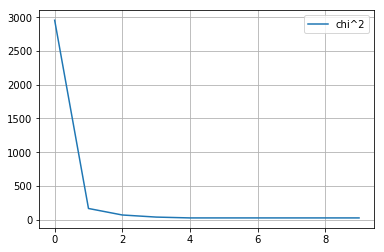

[2957.5185437703685, 164.93093051990334, 68.39298416637806, 37.400152027442125, 25.002827779514657, 25.000045516651948, 25.000000743461005, 25.000000012146504, 25.000000000198455, 25.000000000003226]


In [68]:
def prepare_system(x, P, Q, correspondences):
    H = zeros((3, 3))
    g = zeros((3, 1))
    chi = 0
    for i, j in correspondences:
        p_point = P[:, i]
        q_point = Q[:, j]
        e = error(x, p_point, q_point)
        J = jacobian(x, p_point)
        H += J.T * J
        g += J.T * e
        chi += e.T * e
    return H, g, chi

def icp(P, Q, corresp):
    x = zeros((3, 1))
    chi_values = []
    x_values = [x.copy()]  # Initial value for transformation.
    P_copy = P.copy()
    corresp_values = [corresp]
    for i in range(10):
        correspondences = get_correspondence_indices(P_copy, Q)
        corresp_values.append(correspondences)
        H, g, chi = prepare_system(x, P, Q, correspondences)
        dx = np.linalg.lstsq(H, -g)[0]
        x += dx
        # normalize angle
        x[2] = atan2(sin(x[2]), cos(x[2]))
        # add error to list of errors
        chi_values.append(chi.item(0))
        x_values.append(x.copy())
        rot = R(x[2])
        t = x[0:2]
        P_copy = rot * P.copy() + t
    return x, chi_values, x_values, corresp_values

x, chi_values, x_values, corresp_values = icp(P, Q, correspondences)
plt.plot(chi_values, label="chi^2")
plt.legend()
plt.grid(True)
plt.show()
print(chi_values)


# Animate the result #

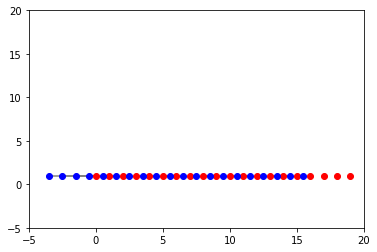

In [69]:
# First set up the figure, the axis, and the plot element we want to animate
fig, anim_ax = plt.subplots()

anim_ax.set_xlim(( -5, 20))
anim_ax.set_ylim((-5, 20))
x_q, y_q = Q.A
# draw initial correspondeces
corresp_lines = []
for i, j in correspondences:
    corresp_lines.append(anim_ax.plot([], [], 'grey')[0])
# draw Q data
Q_line, = anim_ax.plot(x_q, y_q, 'ro')
# prepare empty line for moved data
P_line, = anim_ax.plot([], [], 'bo')

def draw_inc_corresp(P, Q, correspondences):
    for corr_idx, (i, j) in enumerate(correspondences):
        x = [P[0, i], Q[0, j]]
        y = [P[1, i], Q[1, j]]
        corresp_lines[corr_idx].set_data(x, y)

# animation function. This is called sequentially
def animate(i):
    x = x_values[i]
    rot = R(x[2])
    t = x[0:2]
    P_inc = rot * P + t
    x_p, y_p = P_inc.A
    P_line.set_data(x_p, y_p)
    draw_inc_corresp(P_inc, Q, corresp_values[i])
    return (P_line,)

anim = animation.FuncAnimation(fig, animate, frames=len(x_values), interval=500, blit=True)
HTML(anim.to_html5_video())